In [1]:
# Import necessary libraries for image processing and machine learning
from absl import logging  # Import absl for advanced logging
import matplotlib.pyplot as plt  # Import pyplot for plotting images
import numpy as np  # Import numpy for numerical operations
from PIL import Image, ImageOps  # Import Image and ImageOps for image manipulation
from scipy.spatial import cKDTree  # Import cKDTree for quick nearest-neighbor lookup
from skimage.feature import plot_matches  # Import plot_matches to visualize image matches
from skimage.measure import ransac  # Import RANSAC for robust model estimation
from skimage.transform import AffineTransform  # Import AffineTransform for geometric transformations
from six import BytesIO  # Import BytesIO for handling byte streams
import tensorflow as tf  # Import TensorFlow for deep learning functionalities
import tensorflow_hub as hub  # Import tensorflow_hub for loading pre-trained models
from six.moves.urllib.request import urlopen  # Import urlopen to load images from URLs
import time  # Import the time module for time tracking


In [9]:

# User selects an image set based on famous landmarks
img_select = "White House" #@param ["Liberty Tower", "White House", "Piza Tower", "Eiffel tower"]

# URLs for image data based on user selection
if img_select == "Liberty Tower":
    IMAGE_1_URL = 'https://media.timeout.com/images/101382127/image.jpg'
    IMAGE_2_URL = 'https://cdn.britannica.com/71/99571-050-DFF0A6E5/Statue-of-Liberty-Island-New-York.jpg'
elif img_select == "White House":
    IMAGE_1_URL = 'https://www.whitehouse.gov/wp-content/uploads/2022/05/WHAJAC.jpg'
    IMAGE_2_URL = 'https://www.thoughtco.com/thmb/D_Ud8O1MHaMpb_NX6nZ3MPOV2F8=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/GettyImages-117950117-969baa3b88ca430d8e51d6132371fa8e.jpg'
elif img_select == "Piza Tower":
    IMAGE_1_URL = 'https://media.istockphoto.com/id/675711554/photo/piazza-del-duomo-with-leaning-tower-in-pisa.jpg?s=612x612&w=0&k=20&c=hxyEDnZlNM2ih7FS4YeU50Gp4Y_i-6tUxGp2RuYMt6o='
    IMAGE_2_URL = 'https://www.kevinandamanda.com/wp-content/uploads/2018/02/leaning-tower-pisa-lucca-italy-01.jpg'
else:
    IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/d/d8/Eiffel_Tower%2C_November_15%2C_2011.jpg'
    IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/a/a8/Eiffel_Tower_from_immediately_beside_it%2C_Paris_May_2008.jpg'

127166/127166 [==============================] - 0s 2us/step


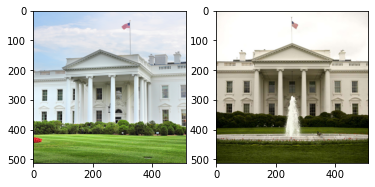

In [10]:
# Function to download and resize images
def download_and_resize(name, url, new_width=512, new_height=512):
    path = tf.keras.utils.get_file(url.split('/')[-1], url)  # Download image
    img = Image.open(path)  # Open image
    img = ImageOps.fit(img, (new_width, new_height), Image.ANTIALIAS)  # Resize and antialias image
    return img

# Download and resize images
img1 = download_and_resize('first_img.jpg', IMAGE_1_URL)
img2 = download_and_resize('second_img.jpg', IMAGE_2_URL)

# Display downloaded images
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

# Load the DELF model from TensorFlow Hub
delf = hub.load('https://tfhub.dev/google/delf/1').signatures['default']

# Function to run DELF to extract features
def run_delf(image):
    np_image = np.array(image)  # Convert image to numpy array
    float_image = tf.image.convert_image_dtype(np_image, tf.float32)  # Convert image pixels to float
    return delf(
        image=float_image,
        score_threshold=tf.constant(100.0),
        image_scales=tf.constant([0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0]),
        max_feature_num=tf.constant(1000))

# Extract features from images
result1 = run_delf(img1)
result2 = run_delf(img2)



# Function to match images based on features
def match_images(img1, img2, result1, result2):
    distance_threshold = 0.8  # Threshold for considering a match
    num_features_1 = result1['locations'].shape[0]  # Number of features in the first image
    print("Loaded image 1's %d features" % num_features_1)
    num_features_2 = result2['locations'].shape[0]  # Number of features in the second image
    print("Loaded image 2's %d features" % num_features_2)

    # Create KD tree for fast feature matching
    d1_tree = cKDTree(result1['descriptors'])
    _, indices = d1_tree.query(
        result2['descriptors'],
        distance_upper_bound=distance_threshold)

    # Filter matches based on the distance threshold
    locations_2_to_use = np.array([
        result2['locations'][i,]
        for i in range(num_features_2)
        if indices[i] != num_features_1
    ])
    locations_1_to_use = np.array([
        result1['locations'][indices[i],]
        for i in range(num_features_2)
        if indices[i] != num_features_1
    ])

    return locations_1_to_use, locations_2_to_use
 

In [11]:
  # Perform geometric verification using RANSAC.
locations_1_to_use, locations_2_to_use = match_images(img1, img2, result1, result2)
_, inliers = ransac(
    (locations_1_to_use, locations_2_to_use),
    AffineTransform,
    min_samples=3,
    residual_threshold=20,
    max_trials=1000)

print('Found %d inliers' % sum(inliers))

Loaded image 1's 495 features
Loaded image 2's 491 features
Found 88 inliers


In [12]:
  # Perform geometric verification using RANSAC.
_, inliers = ransac(
    (locations_1_to_use, locations_2_to_use),
    AffineTransform,
    min_samples=3,
    residual_threshold=20,
    max_trials=1000)

print('Found %d inliers' % sum(inliers))

Found 88 inliers


Text(0.5, 1.0, 'DELF correspondences')

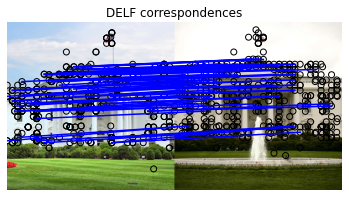

In [13]:
# Visualize correspondences between the matched images
_, ax = plt.subplots()
inlier_idxs = np.nonzero(inliers)[0]
plot_matches(
    ax,
    img1,
    img2,
    locations_1_to_use,
    locations_2_to_use,
    np.column_stack((inlier_idxs, inlier_idxs)),
    matches_color='b')
ax.axis('off')
ax.set_title('DELF correspondences')